In [40]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [41]:
cols = ['engine_id', 'cycle', 'op1', 'op2', 'op3'] + \
       [f'sensor_{i}' for i in range(1, 22)]

df = pd.read_csv(
    '../data/raw/train_FD001.txt',
    delim_whitespace=True,
    header=None,
    names=cols
)

df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_21964\4166429872.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,engine_id,cycle,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [42]:
max_cycles = df.groupby('engine_id')['cycle'].max()
df['RUL'] = df['engine_id'].map(max_cycles) - df['cycle']

df[['engine_id', 'cycle', 'RUL']].tail()


,engine_id,cycle,RUL
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1
20630,100,200,0


In [43]:
RUL_CAP = 130
df['RUL'] = df['RUL'].clip(upper=RUL_CAP)


In [44]:
engine_ids = df['engine_id'].unique()

train_engines, val_engines = train_test_split(
    engine_ids,
    test_size=0.2,
    random_state=42
)

train_df = df[df['engine_id'].isin(train_engines)]
val_df   = df[df['engine_id'].isin(val_engines)]


In [45]:
print("Train engines:", train_df['engine_id'].nunique())
print("Val engines:", val_df['engine_id'].nunique())

assert set(train_engines).isdisjoint(set(val_engines)), "ENGINE LEAKAGE!"


Train engines: 80
Val engines: 20


In [46]:
SENSORS = [
    'sensor_2', 'sensor_3', 'sensor_4',
    'sensor_7', 'sensor_8', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_13',
    'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'
]

X_train = train_df[SENSORS].copy()
y_train = train_df['RUL'].copy()

X_val = val_df[SENSORS].copy()
y_val = val_df['RUL'].copy()


In [47]:
assert not np.array_equal(y_train.values, y_val.values), \
       "y_train and y_val are identical → TARGET LEAKAGE!"

X_train.shape, X_val.shape


((16561, 13), (4070, 13))

In [48]:
imputer = SimpleImputer(strategy="mean")

X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)


In [49]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_imp, y_train)

y_pred_dummy = dummy.predict(X_val_imp)
rmse_dummy = np.sqrt(mean_squared_error(y_val, y_pred_dummy))
rmse_dummy


np.float64(43.474220443929475)

In [50]:
lr = LinearRegression()
lr.fit(X_train_imp, y_train)

y_pred_lr = lr.predict(X_val_imp)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
rmse_lr


np.float64(21.482930147759255)

In [51]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_imp, y_train)

y_pred_rf = rf.predict(X_val_imp)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
rmse_rf


np.float64(18.215397442340937)

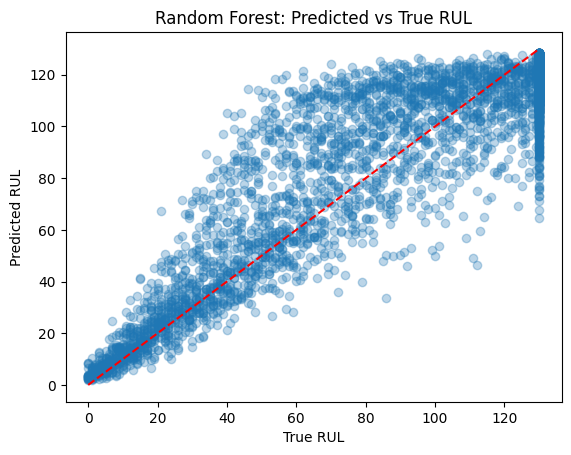

In [52]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_pred_rf, alpha=0.3)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest: Predicted vs True RUL")
plt.plot([0,130],[0,130],'r--')
plt.savefig("../results/figures/rf_pred_vs_true.png")
plt.show()
